In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import poppy
import threading as th
import time 
from IPython.display import clear_output
from importlib import reload
import copy

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import scoobi.scoobi as scoobi
import scoobi.utils as utils
from scoobi.math_module import xp, _scipy, ensure_np_array
from scoobi.imshows import imshow1, imshow2, imshow3

import lina
import lina.psds as psds

from magpyx.utils import ImageStream


/opt/conda/envs/km310env/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [2]:
reload(scoobi)
I = scoobi.SCOOBI(scicam_channel='camsci', dm_channel='dm00disp02')

In [10]:
1/0.002 / 60

8.333333333333334

117.80972461264793 nm


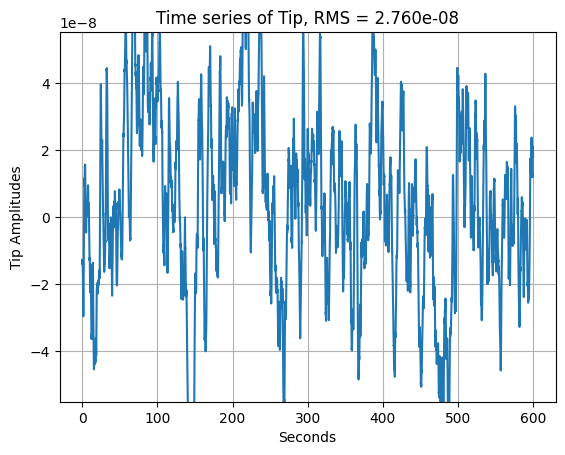

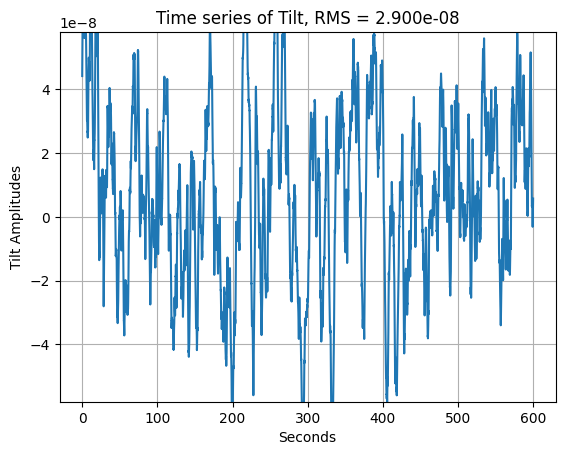

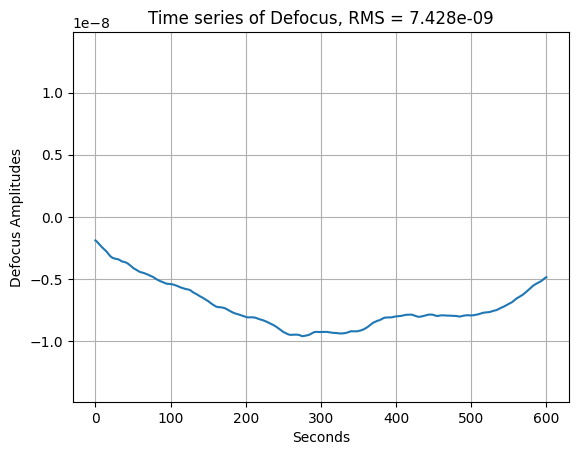

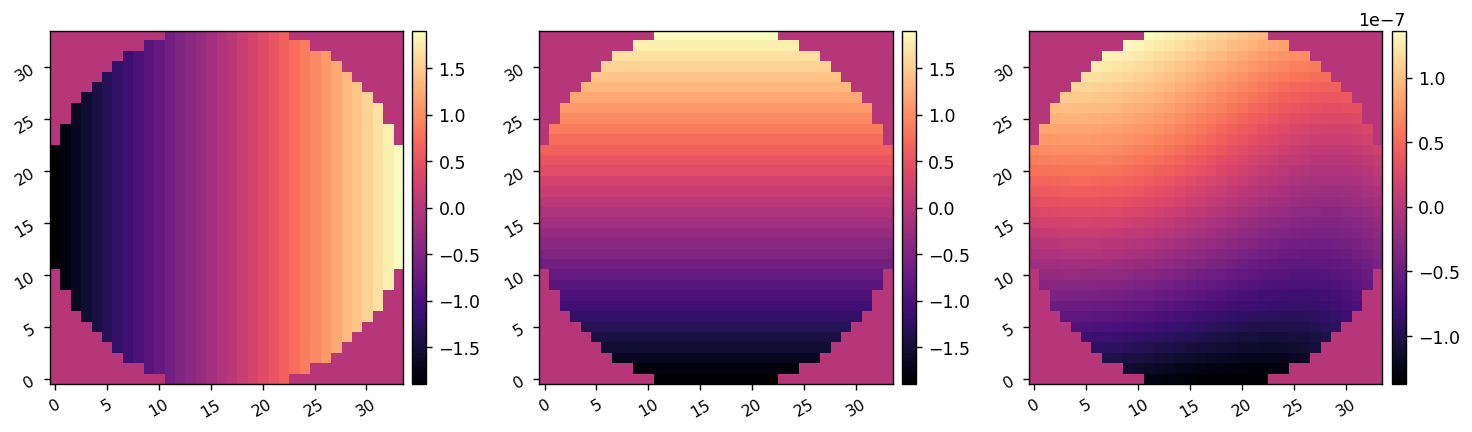

In [24]:
reload(psds)

total_pupil_diam = 2.43*u.m
dm_beam_diam = 9.2*u.mm
jitter = 40*u.mas 

fmax = 250*u.Hz
tmax = 10*u.min

mag = (total_pupil_diam / dm_beam_diam).decompose().value
tt_pv_to_rms = 1/4
tt_at_pupil_pv = np.tan(mag*jitter).value * dm_beam_diam
tt_at_pupil_rms = tt_at_pupil_pv * tt_pv_to_rms
print(tt_at_pupil_rms.to(u.nm))

# wfe_modes_rms = np.array(2*[tt_at_pupil_rms.to_value(u.m)] + 3*[5e-9] + 5*[2.5e-9])
wfe_modes_rms = np.array(2*[30e-9] + 3*[5e-9] + 5*[2.5e-9])
knee_freqs = np.array([0.1]*2 + [0.001]*8) * u.Hz
slope = 4

N_wfe_modes = len(wfe_modes_rms)
wfe_modes = lina.utils.create_zernike_modes(I.dm_mask, nmodes=N_wfe_modes, remove_modes=1)

freqs, times = psds.generate_freqs(Nf=2**22+1, f_max=fmax)

wfe_time_series = xp.zeros((N_wfe_modes, len(times)))
for i in range(N_wfe_modes):
    f_knee = knee_freqs[i]
    psd = psds.kneePSD(freqs, 1, f_knee.to_value(u.Hz), slope)
    coeff = psds.generate_time_series(psd, fmax, rms=1, seed=123+i)
    wfe_time_series[i] = wfe_modes_rms[i] * xp.array(coeff)

wfe_time_series = wfe_time_series[:, times<tmax.to_value(u.s)]

times = times[times<tmax.to_value(u.s)]
tip = wfe_time_series[0]
tilt = wfe_time_series[1]
defocus = wfe_time_series[2]

psds.plot_time_series(times, tip, name='Tip')
psds.plot_time_series(times, tilt, name='Tilt')
psds.plot_time_series(times, defocus, name='Defocus')

lo_wfe = xp.sum( wfe_time_series[:, 500, None, None] * wfe_modes, axis=0)
imshow3(wfe_modes[0], wfe_modes[1], lo_wfe)

In [7]:
wfe_time_series.shape

(10, 30000)

In [7]:
wfe_channel = ImageStream('dm00disp02')

In [25]:
reload(lina.llowfsc)
lina.llowfsc.inject_wfe(ensure_np_array(wfe_time_series)/2, ensure_np_array(wfe_modes), 2*fmax.to_value(u.Hz), wfe_channel)

Injecting WFE ...
Stopped injecting WFE.


In [ ]:
scoobi.set_kilo_mod_amp(1, client0)
scoobi.set_kilo_mod_rate(2*fmax.to_value(u.Hz), client0)

In [ ]:
reload(scoobi)
scoobi.start_kilo_mod(client0, delay=0.1)

In [ ]:
reload(scoobi)
scoobi.stop_kilo_mod(client0, delay=0.1)
